# Module 1.13: Data Quality & Readiness Checks

> **Goal:** Confirm the data is usable for forecasting.


---

## Prerequisites

**Inputs:**
- `./output/m5_weekly_clean.parquet` — From Module 1.9

**What this module produces:**
- Data readiness assessment
- Series-level quality flags
- `./output/series_readiness.parquet`

**Data Flow:**
```
Module 1.12 (leakage guardrails)
    → Module 1.13 (data quality checks) ← YOU ARE HERE
        → Module 1.14 (automated readiness)
```

---

## 1. Why Readiness Checks Matter

Before modeling, confirm:

| Check | Why It Matters |
|-------|----------------|
| **History length** | Models need enough data to learn patterns |
| **Gaps** | Missing periods break lag features |
| **Frequency** | Irregular data confuses time series models |
| **Coverage** | Sparse data may not support forecasting |
| **Duplicates** | Duplicate rows corrupt training |

### The Key Question

> **"Is this data ready for forecasting, or do we need to fix/filter/aggregate first?"**

## 2. Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
Path('./output').mkdir(exist_ok=True)

# Load data
df = pd.read_parquet('./output/m5_weekly_clean.parquet')

# Extract metadata
df['store_id'] = df['unique_id'].str.extract(r'_([A-Z]{2}_\d+)$')[0]
df['dept_id'] = df['unique_id'].str.extract(r'^([A-Z]+_\d+)')[0]
df['cat_id'] = df['unique_id'].str.extract(r'^([A-Z]+)')[0]

print(f"Loaded {len(df):,} rows")
print(f"Series: {df['unique_id'].nunique():,}")
print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")

Loaded 6,848,887 rows
Series: 30,490
Date range: 2011-01-29 to 2016-06-25


## 3. Check 1: History Length

### Minimum History Requirements

| Forecast Horizon | Minimum | Recommended |
|------------------|---------|-------------|
| 1 week | 13 weeks | 52 weeks (1 year) |
| 4 weeks | 26 weeks | 104 weeks (2 years) |
| 13 weeks | 52 weeks | 156 weeks (3 years) |

**Rule of thumb:** 2-3x the forecast horizon, with 2+ seasonal cycles.

In [ ]:
# Calculate history length per series
history_stats = df.groupby('unique_id').agg(
    n_weeks=('ds', 'count'),
    start_date=('ds', 'min'),
    end_date=('ds', 'max')
).reset_index()

tsf.check_history_length(history_stats, min_history=52)

HISTORY LENGTH CHECK
Minimum required: 52 weeks

✅ Sufficient history: 30,334 (99.5%)
❌ Insufficient history: 156

Distribution:
  Min: 19 weeks
  Max: 283 weeks
  Mean: 224.6 weeks


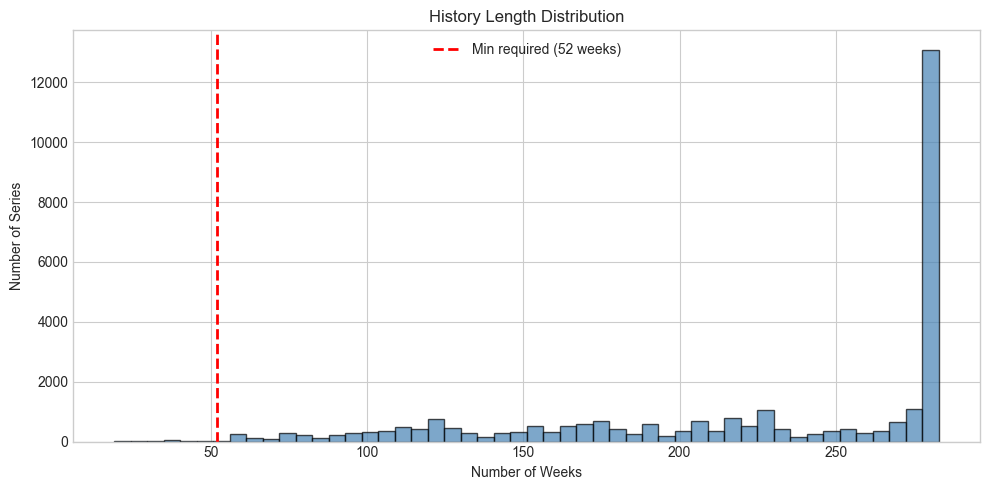

In [ ]:
tsf.plot_history_distribution(history_stats, min_history=52)

## 4. Check 2: Gaps and Completeness

### Gap Types

| Type | Description | Impact |
|------|-------------|--------|
| Internal gaps | Missing weeks within series | Breaks lag features |
| Leading gaps | Late start | Shorter history |
| Trailing gaps | Early end | May be discontinued |

In [ ]:
gap_stats = tsf.analyze_gaps(df, max_gap=10

Analyzing gaps...

GAP ANALYSIS
Maximum allowed: 10%

Series with internal gaps: 0
Series with leading gaps: 23,511
Series with trailing gaps: 0

✅ Acceptable gaps: 30,490 (100.0%)
❌ Too many gaps: 0


## 5. Check 3: Frequency Validation

Confirm data is at expected frequency (weekly).

In [ ]:
freq_issues = tsf.check_frequency(df)

FREQUENCY CHECK
Expected: Weekly (7 days)

✅ All sampled series have consistent weekly frequency


## 6. Check 4: Coverage and Sparsity

### Sparsity Thresholds

| Zero % | Category | Action |
|--------|----------|--------|
| 0-20% | Dense | Standard methods |
| 20-50% | Intermittent | Consider Croston |
| 50-70% | Highly sparse | Specialized methods |
| 70%+ | Sporadic | Aggregate or exclude |

In [ ]:
# Coverage analysis
coverage_stats = df.groupby('unique_id').agg(
    total_weeks=('y', 'count'),
    zero_weeks=('y', lambda x: (x == 0).sum()),
    total_demand=('y', 'sum'),
    mean_demand=('y', 'mean'),
    std_demand=('y', 'std')
).reset_index()

tsf.coverage_analysis(coverage_stats, zero_threshold=0.5, demand_threshold=1)

COVERAGE ANALYSIS

Sparsity Distribution:
sparsity
dense           15533
intermittent    11235
sporadic         3596
sparse            126
Name: count, dtype: int64

Mean zero %: 28.5%

✅ Not sporadic (<=70% zeros): 26,894 (88.2%)
❌ Sporadic (>70% zeros): 3,596


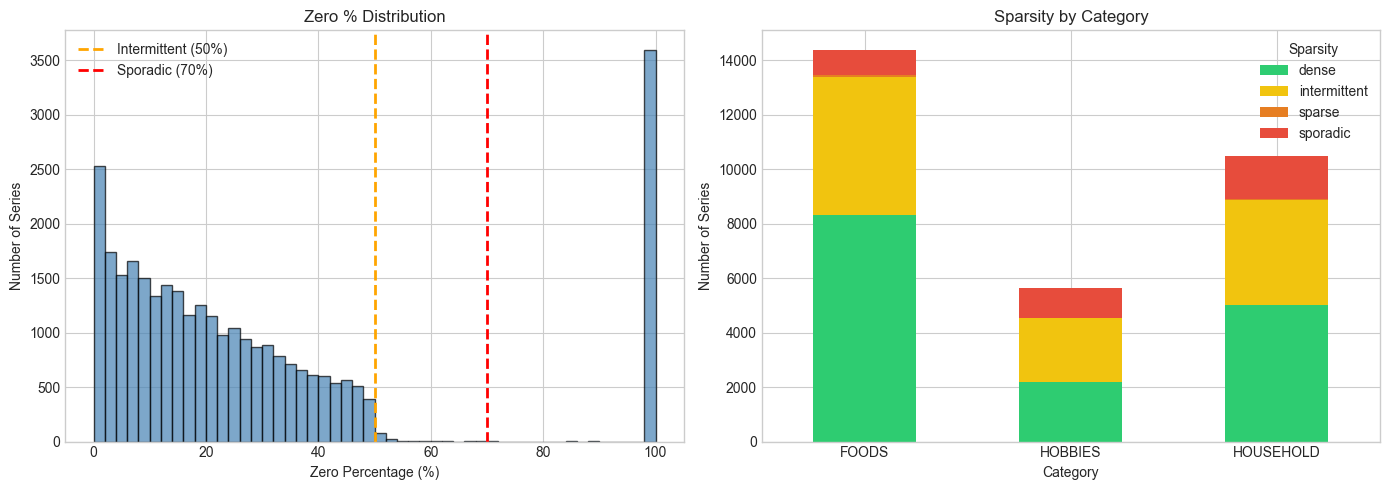

In [ ]:
tsf.plot_sparsity(coverage_stats, zero_threshold=0.5)

## 7. Check 5: Duplicates

Confirm no duplicate (unique_id, ds) combinations.

In [8]:
# Check for duplicates
dup_check = df.groupby(['unique_id', 'ds']).size()
duplicates = dup_check[dup_check > 1]

print("DUPLICATE CHECK")
print("=" * 50)
if len(duplicates) == 0:
    print("✅ No duplicates - data is clean at (unique_id, ds) grain")
else:
    print(f"❌ Found {len(duplicates):,} duplicate (unique_id, ds) combinations")
    print("\nExamples:")
    print(duplicates.head())

DUPLICATE CHECK
✅ No duplicates - data is clean at (unique_id, ds) grain


## 8. Combined Readiness Summary

In [ ]:
# Combine all checks
readiness = history_stats[['unique_id', 'n_weeks', 'sufficient_history']].merge(
    gap_stats[['unique_id', 'internal_gaps', 'gap_pct', 'acceptable_gaps']], 
    on='unique_id'
).merge(
    coverage_stats[['unique_id', 'zero_pct', 'sparsity', 'total_demand', 'is_not_sparse']], 
    on='unique_id'
)

# Overall readiness
readiness['is_ready'] = (
    readiness['sufficient_history'] & 
    readiness['acceptable_gaps'] & 
    readiness['is_not_sparse']
)


tsf.combine_readiness_checks(readiness)

DATA READINESS SUMMARY

Total series: 30,490

Readiness Checks:
  ✅ Sufficient history (>=52 weeks): 30,334 (99.5%)
  ✅ Acceptable gaps (<=10%): 30,490 (100.0%)
  ✅ Not sporadic (<=70% zeros): 26,894 (88.2%)

✅ READY FOR FORECASTING: 26,747 series (87.7%)
❌ NOT READY: 3,743 series


In [ ]:
# Recommendations for not-ready series
not_ready = readiness[~readiness['is_ready']]

tsf.recommend_readiness_actions(not_ready)


RECOMMENDATIONS FOR NOT-READY SERIES
--------------------------------------------------

1. SHORT HISTORY (156 series)
   → Wait for more data or use simple methods (Naive, SES)

3. TOO SPARSE (3,596 series)
   → Aggregate to higher level or use intermittent methods


## 9. Key Takeaways

### Readiness Checklist

| Check | Threshold | If Fail |
|-------|-----------|---------|
| History | >= 52 weeks | Wait or simplify model |
| Gaps | <= 10% | Impute or exclude |
| Zeros | <= 70% | Aggregate or Croston |
| Duplicates | = 0 | Deduplicate |
| Frequency | Consistent | Investigate source |

### Decision Flow

```
Is series ready?
├── YES → Proceed to modeling
└── NO → Why?
    ├── Short history → Wait or use simple methods
    ├── Too many gaps → Impute or exclude
    └── Too sparse → Aggregate up or specialized methods
```

---

## What's Next

**Module 1.14: Automating Readiness**
- Turn these checks into a reusable function
- Generate summary reports automatically

In [11]:
# Save readiness assessment
readiness.to_parquet('./output/series_readiness.parquet', index=False)
readiness.to_csv('./output/series_readiness.csv', index=False)

print("✅ Saved:")
print("  ./output/series_readiness.parquet")
print("  ./output/series_readiness.csv")

print(f"\nReady: {readiness['is_ready'].sum():,} series")
print(f"Not ready: {(~readiness['is_ready']).sum():,} series")

print("\n" + "=" * 60)
print("MODULE 1.13 COMPLETE")
print("=" * 60)

✅ Saved:
  ./output/series_readiness.parquet
  ./output/series_readiness.csv

Ready: 26,747 series
Not ready: 3,743 series

MODULE 1.13 COMPLETE
